# Προεπεξεργασία Εικόνων 
## Δημιουργία Μασκών Θερμικών Αντικειμένων
### Αρχικοποίηση Notebook
- καταχωρούμε αν δεν έχουμε ήδη στο σύστημα το directory του project
- δίνουμε πρόσβαση στο σύστημα για το πχ `C:\Users\plouk\Adiposer`
- Το σύστημα για την ώρα βρίσκεται στο `C:\Users\plouk\anaconda3\python.exe`

### Αποκοπή συνόρων της θερμικής εικόνας
Εκτέλεση της μεθόδου για μια θερμική εικόνα, η οποία εισάγεται ως grayscale

In [29]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from skimage.util import img_as_ubyte
%matplotlib inline
original = imread(fname=module_path + '/data/raw/0h/mouse_1/IR_2066.jpg', as_gray=True)
bordered = original[:, 100:260]

### Σύγκριση αρχικής και αποκομμένης εικόνας 
Επισκόπηση εικόνων και των ιστογραμμάτων τους

Original shape: (240, 320) 
New shape: (240, 160)


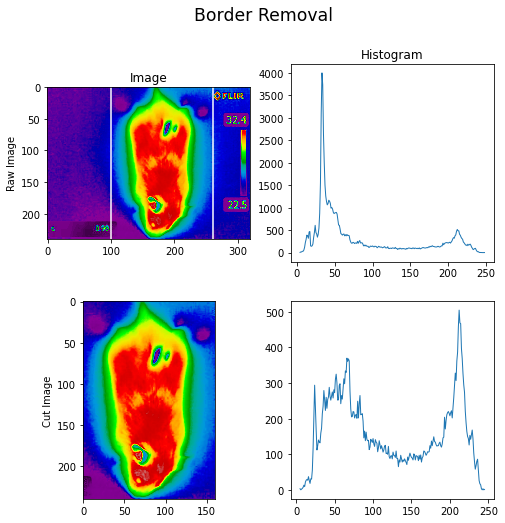

In [30]:

# =======================================================================================
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Border Removal', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.2)

ax = fig.add_subplot(grid[0, 0])
ax.imshow(X=original, cmap=plt.cm.nipy_spectral)
ax.axvline(x=100, c='white')
ax.axvline(x=260, c='white')
ax.set_title(label='Image')
ax.set_ylabel(ylabel='Raw Image')
fig.add_subplot(ax)

ax = fig.add_subplot(grid[0, 1])
histRaw, histRaw_centers = histogram(img_as_ubyte(original))
ax.plot(histRaw_centers, histRaw, lw=1)
ax.set_title(label='Histogram')
fig.add_subplot(ax)

ax = fig.add_subplot(grid[1, 0])
ax.imshow(X=bordered, cmap=plt.cm.nipy_spectral)
ax.set_ylabel(ylabel='Cut Image')
fig.add_subplot(ax)

ax = fig.add_subplot(grid[1, 1])
histCut, histCut_centers = histogram(img_as_ubyte(bordered))
ax.plot(histCut_centers, histCut, lw=1)
fig.add_subplot(ax)
print(f'Original shape: {original.shape} \nNew shape: {bordered.shape}')

### Ιστόγραμμα: Η μείωση των διαστάσεων της εικόνας έχει ως αποτέλεσμα
- Πριν: η κορυφή μετά τα 200 ήταν πολύ χαμηλότερη από τις χαμηλές τιμές ιστογράμματος 
- Μετά: η κορυφή μετά το 200 είναι η μεγαλύτερη σε όλο το ιστόγραμμα
### Μείωση της περιττής πληροφορίας με την αφαίρεση του background

## Κατάτμηση (Segmentation) 
### Δημιουργία Μάσκας για το σώμα του ποντικιού
- Το background (υπόβαθρο) θα αποκτήσει λογική τιμή 0 
- Το θέμα -- foreground (το ποντίκι) αποκτά λογική τιμή 1 
### Πρώτο βήμα: ορισμός 8-bit τιμών background / foreground
- Τα ιστογράμματα έχουν ένα σταθερό χάσμα μεταξύ υψηλών και χαμηλών τιμών 
- Ορίζεται μετά από επισκόπηση πολλών ιστογραμμάτων
    - Δείκτης Background: 70
    - Δείκτης Foreground: 150 

Original shape: (240, 320) 
New shape: (240, 160)


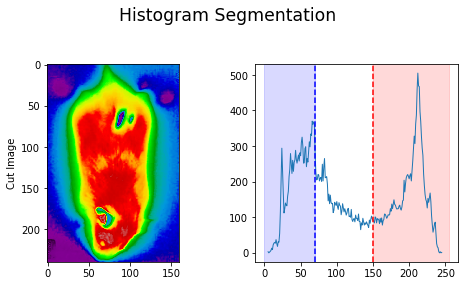

In [31]:
markerBack, markerBody = 70, 150
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Histogram Segmentation', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.2)

ax = fig.add_subplot(grid[0, 0])
ax.imshow(X=bordered, cmap=plt.cm.nipy_spectral)
ax.set_ylabel(ylabel='Cut Image')
fig.add_subplot(ax)

ax = fig.add_subplot(grid[0, 1])
histCut, histCut_centers = histogram(img_as_ubyte(bordered))
ax.plot(histCut_centers, histCut, lw=1)
fig.add_subplot(ax)
print(f'Original shape: {original.shape} \nNew shape: {bordered.shape}')
ax.axvline(x=markerBody, color='red', linestyle='--')
ax.axvline(x=markerBack, color='blue', linestyle='--')
ax.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.15)
ax.axvspan(xmin=0, xmax=markerBack, color='blue', alpha=0.15)

### Παραγωγή Δεικτοδοτημένης Εικόνας
#### Δεικτοδότηση με βάση το ιστόγραμμα
#### Λευκό: Δείκτης Ιστού, Μαύρο: Undefined, Γκρι: Background

Original shape: (240, 320) 
New shape: (240, 160)


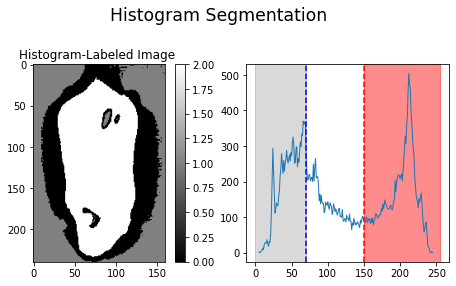

In [32]:
# ===================== 1. Region-based background segmentation ============================
# this mask is going to be topologically processed for the tissue segmentation
# either the BAT which is close to the back neck, or WAT which is close to the belly
# Κάνουμε μια region-based μέθοδο χρησιμοποιώντας την κατάτμηση watershed για μια binary μάσκα.

# We create markers indicating the segmentation through histogram values
markerImage = np.zeros_like(bordered)
# We find markers of the background and the mouse body based on the extreme
# parts of the histogram of gray values.  μαρκάρω == marker, πινακιδιάζω == label
markerBack, markerBody = 70, 150
markerImage[img_as_ubyte(bordered) < markerBack] = 1
markerImage[img_as_ubyte(bordered) > markerBody] = 2


fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Histogram Segmentation', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.2)

ax = fig.add_subplot(grid[0, 0])
ax.set_title('Histogram-Labeled Image ')
img1 = ax.imshow(X=markerImage, cmap=plt.cm.gray)
#ax.set_ylabel(ylabel='Cut Image')
fig.colorbar(img1, ax=ax)
fig.add_subplot(ax)

ax = fig.add_subplot(grid[0, 1])
histCut, histCut_centers = histogram(img_as_ubyte(bordered))
ax.plot(histCut_centers, histCut, lw=1)
fig.add_subplot(ax)
print(f'Original shape: {original.shape} \nNew shape: {bordered.shape}')
ax.axvline(x=markerBody, color='red', linestyle='--')
ax.axvline(x=markerBack, color='blue', linestyle='--')
ax.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.45)
ax.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)

### Παραγωγή εικόνας τελεστή Sobel

<AxesSubplot:title={'center':'Pseudo colored Image'}>

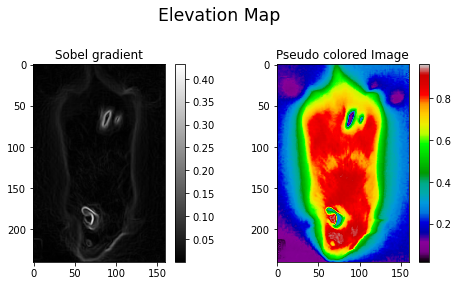

In [33]:
# We use the watershed transform to fill regions of the elevation
# map starting from the markers determined above
# find an elevation map using the image Sobel gradient.
from skimage.filters import sobel 
from skimage.segmentation import watershed

elevationMap = sobel(bordered)
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Elevation Map', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.2)

ax = fig.add_subplot(grid[0, 0])
ax.set_title('Sobel gradient')
img1 = ax.imshow(X=elevationMap, cmap=plt.cm.gray)

fig.colorbar(img1, ax=ax)
fig.add_subplot(ax)

ax = fig.add_subplot(grid[0, 1])
img1 = ax.imshow(X=bordered, cmap=plt.cm.nipy_spectral)
ax.set_title('Pseudo colored Image')
fig.colorbar(img1, ax=ax)
fig.add_subplot(ax)

### Μορφολογική Επεξεργασία και κατασκευή μάσκας

<AxesSubplot:title={'center':'2. Binary Filled Holes'}>

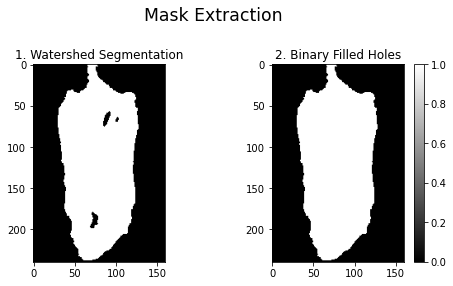

In [34]:
from scipy import ndimage as ndi
initialMaskTemp = watershed(elevationMap, markerImage)
# This method segments and labels the mouse individually
initialMask = ndi.binary_fill_holes(initialMaskTemp - 1)

fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Mask Extraction', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.2)

ax = fig.add_subplot(grid[0, 0])
ax.set_title('1. Watershed Segmentation')
img1 = ax.imshow(X=initialMaskTemp, cmap=plt.cm.gray)
#ax.set_ylabel(ylabel='Cut Image')
fig.add_subplot(ax)

ax = fig.add_subplot(grid[0, 1])
ax.set_title('2. Binary Filled Holes')
img1 = ax.imshow(X=initialMask, cmap=plt.cm.gray)
fig.colorbar(img1, ax=ax)
fig.add_subplot(ax)

### Κουτί Οριοθέτησης Μάσκας 

<AxesSubplot:title={'center':'2. Mask Bounding Box'}>

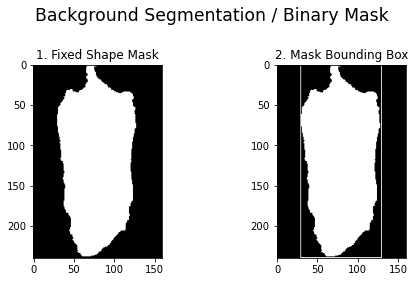

In [35]:
# binary labeling, object and background
from skimage.draw import rectangle_perimeter 
labeledMouse, _ = ndi.label(initialMask)
# βρήκαμε ένα αντικείμενο -ωραία
# επιστρέφει έναν τύπο δεδομένων, που λέγεται slice, ένα τετράγωνο μέσα στην αρχική εικόνα
# είναι σαν generator range object, με διάφορα attributes / methods
mouseLocation = ndi.find_objects(labeledMouse)[0]

fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Background Segmentation / Binary Mask', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)

ax = fig.add_subplot(grid[0, 0])
ax.imshow(X=initialMask, cmap=plt.cm.gray)
ax.set_title(label='1. Fixed Shape Mask')
fig.add_subplot(ax)

ax = fig.add_subplot(grid[0, 1])
ro, co = rectangle_perimeter(start=(mouseLocation[0].start, mouseLocation[1].start), 
                             end=(mouseLocation[0].stop, mouseLocation[1].stop),
                             shape=bordered.shape)
initialMask[ro, co] = True
ax.imshow(X=initialMask, cmap=plt.cm.gray)
ax.set_title(label='2. Mask Bounding Box')
fig.add_subplot(ax)

### Τομή της εικόνας στα όρια της μάσκας 

Previous Shape:(240, 160), Area: 38400 
Bounding Box shape: (238, 98), Area: 23324
Mask Area: 16698


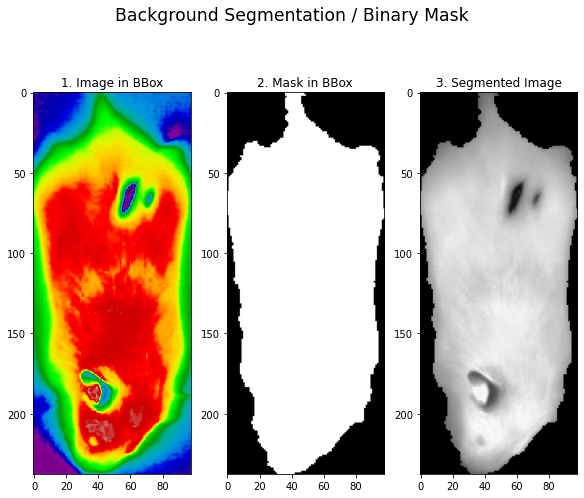

In [40]:
# Μειώνουμε και άλλο στο Bounding Box
mouseImage = bordered[mouseLocation]
mouseMask = initialMask[mouseLocation]
mouseSegmented = mouseMask * mouseImage

fig = plt.figure(figsize=(8, 8), constrained_layout=True)
fig.suptitle(t='Background Segmentation / Binary Mask', fontsize='xx-large')
grid = fig.add_gridspec(nrows=1, ncols=3, wspace=0.2, hspace=0.25)

ax = fig.add_subplot(grid[0, 0])
ax.imshow(X=mouseImage, cmap=plt.cm.nipy_spectral)
ax.set_title(label='1. Image in BBox')
fig.add_subplot(ax)

ax = fig.add_subplot(grid[0, 1])
ax.imshow(X=mouseMask, cmap=plt.cm.gray)
ax.set_title(label='2. Mask in BBox')
fig.add_subplot(ax)

ax = fig.add_subplot(grid[0, 2])
ax.imshow(X=mouseSegmented, cmap=plt.cm.gray)
ax.set_title(label='3. Segmented Image')
fig.add_subplot(ax)

print(f'Previous Shape:{initialMask.shape}, Area: {initialMask.size} \nBounding Box shape: {mouseMask.shape}, Area: {mouseMask.size}')
from src.features import img_to_vectors
ordinateX, ordinateY = img_to_vectors.img_to_vectors(mouseMask)
print(f'Mask Area: {ordinateX.size}')

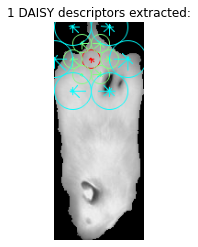

In [50]:
from skimage.feature import daisy
descs, descs_img = daisy(mouseSegmented, step=180, radius=40, rings=2, histograms=6,
                         orientations=8, visualize=True)

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()

In [37]:
import pandas as pd
from skimage.restoration import estimate_sigma
from skimage.measure import shannon_entropy
shapes_dict = {'original': original.shape,
               'without borders': bordered.shape,
               'bounding box': mouseMask.shape}
shapes = pd.Series(shapes_dict)
area_dict = {'original': original.size,
             'without borders': bordered.size,
             'bounding box': mouseMask.size}
area = pd.Series(area_dict)
drop_dict = {'original': 0,
            'without borders': "{:.2f}".format(100*(bordered.size - original.size)/original.size),
            'bounding box': "{:.2f}".format(100*(mouseMask.size - bordered.size)/mouseMask.size)}
drop = pd.Series(drop_dict)
sigma_dict = {'original': estimate_sigma(original),
               'without borders': estimate_sigma(bordered),
               'bounding box': estimate_sigma(mouseImage)}
sigma = pd.Series(sigma_dict)
mean_dict = {'original': np.mean(original),
               'without borders': np.mean(bordered),
               'bounding box': np.mean(mouseImage)}
mean = pd.Series(mean_dict)
entropy_dict = {'original': shannon_entropy(original),
               'without borders': shannon_entropy(bordered),
               'bounding box': shannon_entropy(mouseImage)}
entropy = pd.Series(entropy_dict)
images = pd.DataFrame({'shapes': shapes, 'area': area, 'drop %': drop, 'sigma': sigma, 'mean': mean, 'SNR': sigma/mean, 'entropy': entropy})
images

,shapes,area,drop %,sigma,mean,SNR,entropy
original,"(240, 320)",76800,0,0.001734,0.320489,0.005411,12.430052
without borders,"(240, 160)",38400,-50.00,0.001817,0.481251,0.003776,13.083403
bounding box,"(238, 98)",23324,-64.64,0.001922,0.633960,0.003032,13.069554


### Συμπέρασμα
* Οι μειώσεις της εικόνας στην περιοχή ενδιαφέροντος:
    - Αυξάνεται η διασπορά σ
    - Αυξάνεται η μέση τιμή μ 
    - Μειώνεται το SNR 
    - Αυξάνεται η εντροπία 

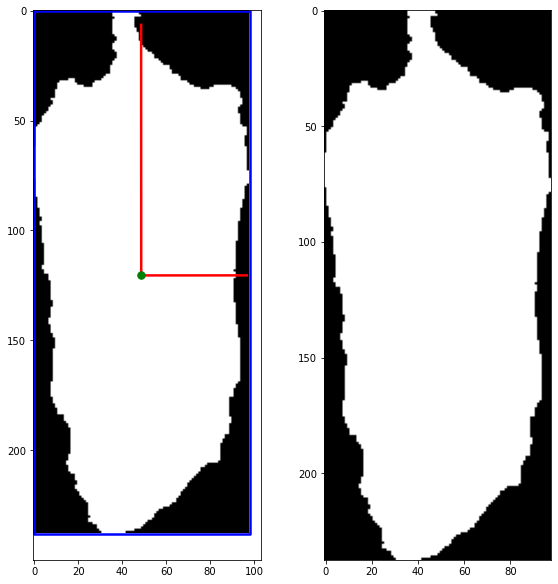

In [61]:
import math
from skimage.measure import label, regionprops, regionprops_table
label_img = label(mouseMask)
regions = regionprops(label_img)
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
# fig.suptitle(t='Background Segmentation / Binary Mask', fontsize='xx-large')
grid = fig.add_gridspec(nrows=1, ncols=2, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(grid[0, 0])
ax.imshow(mouseMask, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)
ax = fig.add_subplot(grid[0, 1])
ax.imshow(regions[0]., cmap=plt.cm.gray)

In [58]:
props = regionprops_table(label_img, properties=('centroid',
                                                 'orientation',
                                                 'major_axis_length',
                                                 'minor_axis_length'))
pd.DataFrame(props)
props = regionprops(label_img)

In [59]:
props[0].convex_image

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])